# Miller age

In [1]:
ood_seed = 15

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Submucosal gland cells', '18.0'), 156)


Removed datapoint: 156

train         5788
validation    1461
ood            156
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 103135.43it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1121945.64it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 276.07it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:02<18:03,  2.72s/it]

Epoch 1/400:   0%|          | 1/400 [00:02<18:03,  2.72s/it, v_num=1, recon=1.19e+3, r2_mean=0.0614, adv_loss=3.52, acc_pert=0.274, acc_integration_donor=0.131]

Epoch 2/400:   0%|          | 1/400 [00:02<18:03,  2.72s/it, v_num=1, recon=1.19e+3, r2_mean=0.0614, adv_loss=3.52, acc_pert=0.274, acc_integration_donor=0.131]

Epoch 2/400:   0%|          | 2/400 [00:04<15:54,  2.40s/it, v_num=1, recon=1.19e+3, r2_mean=0.0614, adv_loss=3.52, acc_pert=0.274, acc_integration_donor=0.131]

Epoch 2/400:   0%|          | 2/400 [00:04<15:54,  2.40s/it, v_num=1, recon=1e+3, r2_mean=0.289, adv_loss=3.08, acc_pert=0.439, acc_integration_donor=0.329]    

Epoch 3/400:   0%|          | 2/400 [00:04<15:54,  2.40s/it, v_num=1, recon=1e+3, r2_mean=0.289, adv_loss=3.08, acc_pert=0.439, acc_integration_donor=0.329]

Epoch 3/400:   1%|          | 3/400 [00:07<15:32,  2.35s/it, v_num=1, recon=1e+3, r2_mean=0.289, adv_loss=3.08, acc_pert=0.439, acc_integration_donor=0.329]

Epoch 3/400:   1%|          | 3/400 [00:07<15:32,  2.35s/it, v_num=1, recon=938, r2_mean=0.39, adv_loss=2.67, acc_pert=0.508, acc_integration_donor=0.482]  

Epoch 4/400:   1%|          | 3/400 [00:07<15:32,  2.35s/it, v_num=1, recon=938, r2_mean=0.39, adv_loss=2.67, acc_pert=0.508, acc_integration_donor=0.482]

Epoch 4/400:   1%|          | 4/400 [00:09<14:59,  2.27s/it, v_num=1, recon=938, r2_mean=0.39, adv_loss=2.67, acc_pert=0.508, acc_integration_donor=0.482]

Epoch 4/400:   1%|          | 4/400 [00:09<14:59,  2.27s/it, v_num=1, recon=900, r2_mean=0.435, adv_loss=2.45, acc_pert=0.541, acc_integration_donor=0.519]

Epoch 5/400:   1%|          | 4/400 [00:09<14:59,  2.27s/it, v_num=1, recon=900, r2_mean=0.435, adv_loss=2.45, acc_pert=0.541, acc_integration_donor=0.519]

Epoch 5/400:   1%|▏         | 5/400 [00:11<14:41,  2.23s/it, v_num=1, recon=900, r2_mean=0.435, adv_loss=2.45, acc_pert=0.541, acc_integration_donor=0.519]

Epoch 5/400:   1%|▏         | 5/400 [00:11<14:41,  2.23s/it, v_num=1, recon=883, r2_mean=0.453, adv_loss=2.33, acc_pert=0.549, acc_integration_donor=0.537]

Epoch 6/400:   1%|▏         | 5/400 [00:11<14:41,  2.23s/it, v_num=1, recon=883, r2_mean=0.453, adv_loss=2.33, acc_pert=0.549, acc_integration_donor=0.537]

Epoch 6/400:   2%|▏         | 6/400 [00:13<14:31,  2.21s/it, v_num=1, recon=883, r2_mean=0.453, adv_loss=2.33, acc_pert=0.549, acc_integration_donor=0.537]

Epoch 6/400:   2%|▏         | 6/400 [00:13<14:31,  2.21s/it, v_num=1, recon=871, r2_mean=0.465, adv_loss=2.31, acc_pert=0.531, acc_integration_donor=0.531]

Epoch 7/400:   2%|▏         | 6/400 [00:13<14:31,  2.21s/it, v_num=1, recon=871, r2_mean=0.465, adv_loss=2.31, acc_pert=0.531, acc_integration_donor=0.531]

Epoch 7/400:   2%|▏         | 7/400 [00:15<14:28,  2.21s/it, v_num=1, recon=871, r2_mean=0.465, adv_loss=2.31, acc_pert=0.531, acc_integration_donor=0.531]

Epoch 7/400:   2%|▏         | 7/400 [00:15<14:28,  2.21s/it, v_num=1, recon=863, r2_mean=0.475, adv_loss=2.27, acc_pert=0.537, acc_integration_donor=0.542]

Epoch 8/400:   2%|▏         | 7/400 [00:15<14:28,  2.21s/it, v_num=1, recon=863, r2_mean=0.475, adv_loss=2.27, acc_pert=0.537, acc_integration_donor=0.542]

Epoch 8/400:   2%|▏         | 8/400 [00:18<14:21,  2.20s/it, v_num=1, recon=863, r2_mean=0.475, adv_loss=2.27, acc_pert=0.537, acc_integration_donor=0.542]

Epoch 8/400:   2%|▏         | 8/400 [00:18<14:21,  2.20s/it, v_num=1, recon=857, r2_mean=0.48, adv_loss=2.21, acc_pert=0.549, acc_integration_donor=0.533] 

Epoch 9/400:   2%|▏         | 8/400 [00:18<14:21,  2.20s/it, v_num=1, recon=857, r2_mean=0.48, adv_loss=2.21, acc_pert=0.549, acc_integration_donor=0.533]

Epoch 9/400:   2%|▏         | 9/400 [00:20<14:13,  2.18s/it, v_num=1, recon=857, r2_mean=0.48, adv_loss=2.21, acc_pert=0.549, acc_integration_donor=0.533]

Epoch 9/400:   2%|▏         | 9/400 [00:20<14:13,  2.18s/it, v_num=1, recon=849, r2_mean=0.488, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.517]

Epoch 10/400:   2%|▏         | 9/400 [00:20<14:13,  2.18s/it, v_num=1, recon=849, r2_mean=0.488, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.517]


disnt_basal = 0.5305713615168292

disnt_after = 0.9319062743970115

val_r2_mean = 0.5187108110459078

val_r2_var = 0.22036459137286457


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:23<17:16,  2.66s/it, v_num=1, recon=849, r2_mean=0.488, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.517]

Epoch 10/400:   2%|▎         | 10/400 [00:23<17:16,  2.66s/it, v_num=1, recon=845, r2_mean=0.496, adv_loss=2.18, acc_pert=0.558, acc_integration_donor=0.513, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:23<17:16,  2.66s/it, v_num=1, recon=845, r2_mean=0.496, adv_loss=2.18, acc_pert=0.558, acc_integration_donor=0.513, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:26<16:20,  2.52s/it, v_num=1, recon=845, r2_mean=0.496, adv_loss=2.18, acc_pert=0.558, acc_integration_donor=0.513, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:26<16:20,  2.52s/it, v_num=1, recon=839, r2_mean=0.499, adv_loss=2.17, acc_pert=0.553, acc_integration_donor=0.523, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:26<16:20,  2.52s/it, v_num=1, recon=839, r2_mean=0.499, adv_loss=2.17, acc_pert=0.553, acc_integration_donor=0.523, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:28<15:33,  2.41s/it, v_num=1, recon=839, r2_mean=0.499, adv_loss=2.17, acc_pert=0.553, acc_integration_donor=0.523, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:28<15:33,  2.41s/it, v_num=1, recon=836, r2_mean=0.502, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.517, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:28<15:33,  2.41s/it, v_num=1, recon=836, r2_mean=0.502, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.517, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:30<15:02,  2.33s/it, v_num=1, recon=836, r2_mean=0.502, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.517, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:30<15:02,  2.33s/it, v_num=1, recon=834, r2_mean=0.508, adv_loss=2.19, acc_pert=0.55, acc_integration_donor=0.513, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [00:30<15:02,  2.33s/it, v_num=1, recon=834, r2_mean=0.508, adv_loss=2.19, acc_pert=0.55, acc_integration_donor=0.513, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:32<14:41,  2.28s/it, v_num=1, recon=834, r2_mean=0.508, adv_loss=2.19, acc_pert=0.55, acc_integration_donor=0.513, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:32<14:41,  2.28s/it, v_num=1, recon=828, r2_mean=0.51, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.521, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:32<14:41,  2.28s/it, v_num=1, recon=828, r2_mean=0.51, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.521, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:34<14:28,  2.26s/it, v_num=1, recon=828, r2_mean=0.51, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.521, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:34<14:28,  2.26s/it, v_num=1, recon=829, r2_mean=0.515, adv_loss=2.16, acc_pert=0.563, acc_integration_donor=0.513, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:34<14:28,  2.26s/it, v_num=1, recon=829, r2_mean=0.515, adv_loss=2.16, acc_pert=0.563, acc_integration_donor=0.513, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:37<14:25,  2.25s/it, v_num=1, recon=829, r2_mean=0.515, adv_loss=2.16, acc_pert=0.563, acc_integration_donor=0.513, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:37<14:25,  2.25s/it, v_num=1, recon=825, r2_mean=0.518, adv_loss=2.18, acc_pert=0.557, acc_integration_donor=0.515, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:37<14:25,  2.25s/it, v_num=1, recon=825, r2_mean=0.518, adv_loss=2.18, acc_pert=0.557, acc_integration_donor=0.515, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:39<14:12,  2.22s/it, v_num=1, recon=825, r2_mean=0.518, adv_loss=2.18, acc_pert=0.557, acc_integration_donor=0.515, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:39<14:12,  2.22s/it, v_num=1, recon=822, r2_mean=0.517, adv_loss=2.16, acc_pert=0.551, acc_integration_donor=0.516, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:39<14:12,  2.22s/it, v_num=1, recon=822, r2_mean=0.517, adv_loss=2.16, acc_pert=0.551, acc_integration_donor=0.516, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:41<14:03,  2.21s/it, v_num=1, recon=822, r2_mean=0.517, adv_loss=2.16, acc_pert=0.551, acc_integration_donor=0.516, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:41<14:03,  2.21s/it, v_num=1, recon=818, r2_mean=0.521, adv_loss=2.16, acc_pert=0.563, acc_integration_donor=0.519, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [00:41<14:03,  2.21s/it, v_num=1, recon=818, r2_mean=0.521, adv_loss=2.16, acc_pert=0.563, acc_integration_donor=0.519, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:43<14:05,  2.22s/it, v_num=1, recon=818, r2_mean=0.521, adv_loss=2.16, acc_pert=0.563, acc_integration_donor=0.519, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:43<14:05,  2.22s/it, v_num=1, recon=819, r2_mean=0.526, adv_loss=2.16, acc_pert=0.554, acc_integration_donor=0.508, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:43<14:05,  2.22s/it, v_num=1, recon=819, r2_mean=0.526, adv_loss=2.16, acc_pert=0.554, acc_integration_donor=0.508, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]


disnt_basal = 0.5063261083847355

disnt_after = 0.899599064575833

val_r2_mean = 0.5156409665942192

val_r2_var = 0.31999667299290496


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [00:47<16:58,  2.68s/it, v_num=1, recon=819, r2_mean=0.526, adv_loss=2.16, acc_pert=0.554, acc_integration_donor=0.508, val_recon=850, disnt_basal=0.531, disnt_after=0.932, val_r2_mean=0.519, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [00:47<16:58,  2.68s/it, v_num=1, recon=818, r2_mean=0.528, adv_loss=2.18, acc_pert=0.554, acc_integration_donor=0.504, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]  

Epoch 21/400:   5%|▌         | 20/400 [00:47<16:58,  2.68s/it, v_num=1, recon=818, r2_mean=0.528, adv_loss=2.18, acc_pert=0.554, acc_integration_donor=0.504, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [00:49<16:02,  2.54s/it, v_num=1, recon=818, r2_mean=0.528, adv_loss=2.18, acc_pert=0.554, acc_integration_donor=0.504, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [00:49<16:02,  2.54s/it, v_num=1, recon=817, r2_mean=0.533, adv_loss=2.17, acc_pert=0.553, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [00:49<16:02,  2.54s/it, v_num=1, recon=817, r2_mean=0.533, adv_loss=2.17, acc_pert=0.553, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [00:51<15:27,  2.45s/it, v_num=1, recon=817, r2_mean=0.533, adv_loss=2.17, acc_pert=0.553, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [00:51<15:27,  2.45s/it, v_num=1, recon=810, r2_mean=0.532, adv_loss=2.16, acc_pert=0.549, acc_integration_donor=0.526, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [00:51<15:27,  2.45s/it, v_num=1, recon=810, r2_mean=0.532, adv_loss=2.16, acc_pert=0.549, acc_integration_donor=0.526, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [00:54<15:16,  2.43s/it, v_num=1, recon=810, r2_mean=0.532, adv_loss=2.16, acc_pert=0.549, acc_integration_donor=0.526, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [00:54<15:16,  2.43s/it, v_num=1, recon=812, r2_mean=0.525, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [00:54<15:16,  2.43s/it, v_num=1, recon=812, r2_mean=0.525, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [00:56<14:42,  2.35s/it, v_num=1, recon=812, r2_mean=0.525, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [00:56<14:42,  2.35s/it, v_num=1, recon=812, r2_mean=0.534, adv_loss=2.17, acc_pert=0.551, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [00:56<14:42,  2.35s/it, v_num=1, recon=812, r2_mean=0.534, adv_loss=2.17, acc_pert=0.551, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [00:58<14:26,  2.31s/it, v_num=1, recon=812, r2_mean=0.534, adv_loss=2.17, acc_pert=0.551, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [00:58<14:26,  2.31s/it, v_num=1, recon=807, r2_mean=0.536, adv_loss=2.18, acc_pert=0.552, acc_integration_donor=0.521, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [00:58<14:26,  2.31s/it, v_num=1, recon=807, r2_mean=0.536, adv_loss=2.18, acc_pert=0.552, acc_integration_donor=0.521, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:00<14:09,  2.27s/it, v_num=1, recon=807, r2_mean=0.536, adv_loss=2.18, acc_pert=0.552, acc_integration_donor=0.521, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:00<14:09,  2.27s/it, v_num=1, recon=807, r2_mean=0.537, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:00<14:09,  2.27s/it, v_num=1, recon=807, r2_mean=0.537, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:03<14:11,  2.28s/it, v_num=1, recon=807, r2_mean=0.537, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:03<14:11,  2.28s/it, v_num=1, recon=811, r2_mean=0.535, adv_loss=2.2, acc_pert=0.547, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan] 

Epoch 28/400:   7%|▋         | 27/400 [01:03<14:11,  2.28s/it, v_num=1, recon=811, r2_mean=0.535, adv_loss=2.2, acc_pert=0.547, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:05<13:47,  2.23s/it, v_num=1, recon=811, r2_mean=0.535, adv_loss=2.2, acc_pert=0.547, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:05<13:47,  2.23s/it, v_num=1, recon=808, r2_mean=0.542, adv_loss=2.19, acc_pert=0.546, acc_integration_donor=0.521, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:05<13:47,  2.23s/it, v_num=1, recon=808, r2_mean=0.542, adv_loss=2.19, acc_pert=0.546, acc_integration_donor=0.521, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:07<13:43,  2.22s/it, v_num=1, recon=808, r2_mean=0.542, adv_loss=2.19, acc_pert=0.546, acc_integration_donor=0.521, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:07<13:43,  2.22s/it, v_num=1, recon=805, r2_mean=0.542, adv_loss=2.21, acc_pert=0.543, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:07<13:43,  2.22s/it, v_num=1, recon=805, r2_mean=0.542, adv_loss=2.21, acc_pert=0.543, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]


disnt_basal = 0.5046246224918555

disnt_after = 0.8769688208783318

val_r2_mean = 0.5221120876570543

val_r2_var = 0.3566646023343007

Epoch 30/400:   8%|▊         | 30/400 [01:11<16:37,  2.70s/it, v_num=1, recon=805, r2_mean=0.542, adv_loss=2.21, acc_pert=0.543, acc_integration_donor=0.516, val_recon=836, disnt_basal=0.506, disnt_after=0.9, val_r2_mean=0.516, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:11<16:37,  2.70s/it, v_num=1, recon=802, r2_mean=0.538, adv_loss=2.2, acc_pert=0.544, acc_integration_donor=0.515, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:11<16:37,  2.70s/it, v_num=1, recon=802, r2_mean=0.538, adv_loss=2.2, acc_pert=0.544, acc_integration_donor=0.515, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:13<15:32,  2.53s/it, v_num=1, recon=802, r2_mean=0.538, adv_loss=2.2, acc_pert=0.544, acc_integration_donor=0.515, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:13<15:32,  2.53s/it, v_num=1, recon=804, r2_mean=0.543, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.525, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:13<15:32,  2.53s/it, v_num=1, recon=804, r2_mean=0.543, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.525, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:15<14:57,  2.44s/it, v_num=1, recon=804, r2_mean=0.543, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.525, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:15<14:57,  2.44s/it, v_num=1, recon=803, r2_mean=0.543, adv_loss=2.21, acc_pert=0.532, acc_integration_donor=0.518, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [01:15<14:57,  2.44s/it, v_num=1, recon=803, r2_mean=0.543, adv_loss=2.21, acc_pert=0.532, acc_integration_donor=0.518, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:17<14:28,  2.37s/it, v_num=1, recon=803, r2_mean=0.543, adv_loss=2.21, acc_pert=0.532, acc_integration_donor=0.518, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:17<14:28,  2.37s/it, v_num=1, recon=799, r2_mean=0.549, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [01:17<14:28,  2.37s/it, v_num=1, recon=799, r2_mean=0.549, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:19<14:12,  2.33s/it, v_num=1, recon=799, r2_mean=0.549, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:19<14:12,  2.33s/it, v_num=1, recon=797, r2_mean=0.545, adv_loss=2.25, acc_pert=0.528, acc_integration_donor=0.507, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [01:19<14:12,  2.33s/it, v_num=1, recon=797, r2_mean=0.545, adv_loss=2.25, acc_pert=0.528, acc_integration_donor=0.507, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:22<13:59,  2.30s/it, v_num=1, recon=797, r2_mean=0.545, adv_loss=2.25, acc_pert=0.528, acc_integration_donor=0.507, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:22<13:59,  2.30s/it, v_num=1, recon=801, r2_mean=0.547, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.507, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [01:22<13:59,  2.30s/it, v_num=1, recon=801, r2_mean=0.547, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.507, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:24<13:50,  2.28s/it, v_num=1, recon=801, r2_mean=0.547, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.507, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:24<13:50,  2.28s/it, v_num=1, recon=798, r2_mean=0.547, adv_loss=2.27, acc_pert=0.522, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [01:24<13:50,  2.28s/it, v_num=1, recon=798, r2_mean=0.547, adv_loss=2.27, acc_pert=0.522, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:26<13:26,  2.22s/it, v_num=1, recon=798, r2_mean=0.547, adv_loss=2.27, acc_pert=0.522, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:26<13:26,  2.22s/it, v_num=1, recon=797, r2_mean=0.549, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.506, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [01:26<13:26,  2.22s/it, v_num=1, recon=797, r2_mean=0.549, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.506, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:28<13:27,  2.23s/it, v_num=1, recon=797, r2_mean=0.549, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.506, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:28<13:27,  2.23s/it, v_num=1, recon=797, r2_mean=0.547, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [01:28<13:27,  2.23s/it, v_num=1, recon=797, r2_mean=0.547, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:31<13:25,  2.23s/it, v_num=1, recon=797, r2_mean=0.547, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:31<13:25,  2.23s/it, v_num=1, recon=796, r2_mean=0.551, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.508, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [01:31<13:25,  2.23s/it, v_num=1, recon=796, r2_mean=0.551, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.508, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]


disnt_basal = 0.48581437412259

disnt_after = 0.9236451538893277

val_r2_mean = 0.524150080890173

val_r2_var = 0.37144980251434306


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [01:34<16:01,  2.67s/it, v_num=1, recon=796, r2_mean=0.551, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.508, val_recon=824, disnt_basal=0.505, disnt_after=0.877, val_r2_mean=0.522, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [01:34<16:01,  2.67s/it, v_num=1, recon=794, r2_mean=0.551, adv_loss=2.3, acc_pert=0.511, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan] 

Epoch 41/400:  10%|█         | 40/400 [01:34<16:01,  2.67s/it, v_num=1, recon=794, r2_mean=0.551, adv_loss=2.3, acc_pert=0.511, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [01:36<15:07,  2.53s/it, v_num=1, recon=794, r2_mean=0.551, adv_loss=2.3, acc_pert=0.511, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [01:36<15:07,  2.53s/it, v_num=1, recon=792, r2_mean=0.554, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.507, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [01:36<15:07,  2.53s/it, v_num=1, recon=792, r2_mean=0.554, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.507, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [01:39<14:31,  2.44s/it, v_num=1, recon=792, r2_mean=0.554, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.507, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [01:39<14:31,  2.44s/it, v_num=1, recon=791, r2_mean=0.554, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.509, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [01:39<14:31,  2.44s/it, v_num=1, recon=791, r2_mean=0.554, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.509, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [01:41<14:02,  2.36s/it, v_num=1, recon=791, r2_mean=0.554, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.509, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [01:41<14:02,  2.36s/it, v_num=1, recon=793, r2_mean=0.557, adv_loss=2.29, acc_pert=0.499, acc_integration_donor=0.506, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [01:41<14:02,  2.36s/it, v_num=1, recon=793, r2_mean=0.557, adv_loss=2.29, acc_pert=0.499, acc_integration_donor=0.506, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [01:43<13:39,  2.30s/it, v_num=1, recon=793, r2_mean=0.557, adv_loss=2.29, acc_pert=0.499, acc_integration_donor=0.506, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [01:43<13:39,  2.30s/it, v_num=1, recon=793, r2_mean=0.556, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.506, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [01:43<13:39,  2.30s/it, v_num=1, recon=793, r2_mean=0.556, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.506, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [01:45<13:29,  2.28s/it, v_num=1, recon=793, r2_mean=0.556, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.506, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [01:45<13:29,  2.28s/it, v_num=1, recon=789, r2_mean=0.555, adv_loss=2.3, acc_pert=0.504, acc_integration_donor=0.511, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [01:45<13:29,  2.28s/it, v_num=1, recon=789, r2_mean=0.555, adv_loss=2.3, acc_pert=0.504, acc_integration_donor=0.511, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [01:47<13:18,  2.26s/it, v_num=1, recon=789, r2_mean=0.555, adv_loss=2.3, acc_pert=0.504, acc_integration_donor=0.511, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [01:47<13:18,  2.26s/it, v_num=1, recon=788, r2_mean=0.551, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [01:47<13:18,  2.26s/it, v_num=1, recon=788, r2_mean=0.551, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [01:50<13:07,  2.23s/it, v_num=1, recon=788, r2_mean=0.551, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.514, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [01:50<13:07,  2.23s/it, v_num=1, recon=791, r2_mean=0.559, adv_loss=2.3, acc_pert=0.494, acc_integration_donor=0.515, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan] 

Epoch 48/400:  12%|█▏        | 47/400 [01:50<13:07,  2.23s/it, v_num=1, recon=791, r2_mean=0.559, adv_loss=2.3, acc_pert=0.494, acc_integration_donor=0.515, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [01:52<12:59,  2.22s/it, v_num=1, recon=791, r2_mean=0.559, adv_loss=2.3, acc_pert=0.494, acc_integration_donor=0.515, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [01:52<12:59,  2.22s/it, v_num=1, recon=791, r2_mean=0.554, adv_loss=2.3, acc_pert=0.504, acc_integration_donor=0.518, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [01:52<12:59,  2.22s/it, v_num=1, recon=791, r2_mean=0.554, adv_loss=2.3, acc_pert=0.504, acc_integration_donor=0.518, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [01:54<12:55,  2.21s/it, v_num=1, recon=791, r2_mean=0.554, adv_loss=2.3, acc_pert=0.504, acc_integration_donor=0.518, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [01:54<12:55,  2.21s/it, v_num=1, recon=785, r2_mean=0.562, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.519, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [01:54<12:55,  2.21s/it, v_num=1, recon=785, r2_mean=0.562, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.519, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]


disnt_basal = 0.4816566238204225

disnt_after = 0.9098074063720735

val_r2_mean = 0.525592832515637

val_r2_var = 0.3720649443566799

Epoch 50/400:  12%|█▎        | 50/400 [01:58<15:17,  2.62s/it, v_num=1, recon=785, r2_mean=0.562, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.519, val_recon=824, disnt_basal=0.486, disnt_after=0.924, val_r2_mean=0.524, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [01:58<15:17,  2.62s/it, v_num=1, recon=784, r2_mean=0.558, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.509, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [01:58<15:17,  2.62s/it, v_num=1, recon=784, r2_mean=0.558, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.509, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:00<14:28,  2.49s/it, v_num=1, recon=784, r2_mean=0.558, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.509, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:00<14:28,  2.49s/it, v_num=1, recon=784, r2_mean=0.559, adv_loss=2.3, acc_pert=0.51, acc_integration_donor=0.511, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]  

Epoch 52/400:  13%|█▎        | 51/400 [02:00<14:28,  2.49s/it, v_num=1, recon=784, r2_mean=0.559, adv_loss=2.3, acc_pert=0.51, acc_integration_donor=0.511, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:02<13:48,  2.38s/it, v_num=1, recon=784, r2_mean=0.559, adv_loss=2.3, acc_pert=0.51, acc_integration_donor=0.511, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:02<13:48,  2.38s/it, v_num=1, recon=783, r2_mean=0.564, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [02:02<13:48,  2.38s/it, v_num=1, recon=783, r2_mean=0.564, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:04<13:25,  2.32s/it, v_num=1, recon=783, r2_mean=0.564, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.512, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:04<13:25,  2.32s/it, v_num=1, recon=781, r2_mean=0.56, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.501, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [02:04<13:25,  2.32s/it, v_num=1, recon=781, r2_mean=0.56, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.501, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:06<13:03,  2.27s/it, v_num=1, recon=781, r2_mean=0.56, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.501, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:06<13:03,  2.27s/it, v_num=1, recon=784, r2_mean=0.56, adv_loss=2.33, acc_pert=0.513, acc_integration_donor=0.511, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [02:06<13:03,  2.27s/it, v_num=1, recon=784, r2_mean=0.56, adv_loss=2.33, acc_pert=0.513, acc_integration_donor=0.511, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:08<12:49,  2.23s/it, v_num=1, recon=784, r2_mean=0.56, adv_loss=2.33, acc_pert=0.513, acc_integration_donor=0.511, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:08<12:49,  2.23s/it, v_num=1, recon=780, r2_mean=0.562, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.501, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [02:08<12:49,  2.23s/it, v_num=1, recon=780, r2_mean=0.562, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.501, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:10<12:30,  2.18s/it, v_num=1, recon=780, r2_mean=0.562, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.501, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:10<12:30,  2.18s/it, v_num=1, recon=782, r2_mean=0.558, adv_loss=2.31, acc_pert=0.52, acc_integration_donor=0.508, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [02:10<12:30,  2.18s/it, v_num=1, recon=782, r2_mean=0.558, adv_loss=2.31, acc_pert=0.52, acc_integration_donor=0.508, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:13<12:23,  2.17s/it, v_num=1, recon=782, r2_mean=0.558, adv_loss=2.31, acc_pert=0.52, acc_integration_donor=0.508, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:13<12:23,  2.17s/it, v_num=1, recon=777, r2_mean=0.57, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.504, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [02:13<12:23,  2.17s/it, v_num=1, recon=777, r2_mean=0.57, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.504, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:15<12:31,  2.20s/it, v_num=1, recon=777, r2_mean=0.57, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.504, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:15<12:31,  2.20s/it, v_num=1, recon=777, r2_mean=0.563, adv_loss=2.36, acc_pert=0.489, acc_integration_donor=0.501, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [02:15<12:31,  2.20s/it, v_num=1, recon=777, r2_mean=0.563, adv_loss=2.36, acc_pert=0.489, acc_integration_donor=0.501, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:17<12:30,  2.20s/it, v_num=1, recon=777, r2_mean=0.563, adv_loss=2.36, acc_pert=0.489, acc_integration_donor=0.501, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:17<12:30,  2.20s/it, v_num=1, recon=775, r2_mean=0.563, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.506, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [02:17<12:30,  2.20s/it, v_num=1, recon=775, r2_mean=0.563, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.506, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]


disnt_basal = 0.469184118176932

disnt_after = 0.9221717863295691

val_r2_mean = 0.5242272013177475

val_r2_var = 0.3853213470429182


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [02:21<14:52,  2.63s/it, v_num=1, recon=775, r2_mean=0.563, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.506, val_recon=820, disnt_basal=0.482, disnt_after=0.91, val_r2_mean=0.526, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [02:21<14:52,  2.63s/it, v_num=1, recon=775, r2_mean=0.566, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.502, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [02:21<14:52,  2.63s/it, v_num=1, recon=775, r2_mean=0.566, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.502, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [02:23<14:02,  2.49s/it, v_num=1, recon=775, r2_mean=0.566, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.502, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [02:23<14:02,  2.49s/it, v_num=1, recon=778, r2_mean=0.564, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.498, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [02:23<14:02,  2.49s/it, v_num=1, recon=778, r2_mean=0.564, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.498, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [02:25<13:37,  2.42s/it, v_num=1, recon=778, r2_mean=0.564, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.498, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [02:25<13:37,  2.42s/it, v_num=1, recon=775, r2_mean=0.569, adv_loss=2.37, acc_pert=0.484, acc_integration_donor=0.508, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [02:25<13:37,  2.42s/it, v_num=1, recon=775, r2_mean=0.569, adv_loss=2.37, acc_pert=0.484, acc_integration_donor=0.508, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [02:27<13:29,  2.40s/it, v_num=1, recon=775, r2_mean=0.569, adv_loss=2.37, acc_pert=0.484, acc_integration_donor=0.508, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [02:27<13:29,  2.40s/it, v_num=1, recon=774, r2_mean=0.569, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.505, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [02:27<13:29,  2.40s/it, v_num=1, recon=774, r2_mean=0.569, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.505, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [02:30<13:14,  2.37s/it, v_num=1, recon=774, r2_mean=0.569, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.505, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [02:30<13:14,  2.37s/it, v_num=1, recon=774, r2_mean=0.566, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.506, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [02:30<13:14,  2.37s/it, v_num=1, recon=774, r2_mean=0.566, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.506, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [02:32<12:59,  2.33s/it, v_num=1, recon=774, r2_mean=0.566, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.506, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [02:32<12:59,  2.33s/it, v_num=1, recon=774, r2_mean=0.562, adv_loss=2.41, acc_pert=0.489, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [02:32<12:59,  2.33s/it, v_num=1, recon=774, r2_mean=0.562, adv_loss=2.41, acc_pert=0.489, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [02:34<12:57,  2.33s/it, v_num=1, recon=774, r2_mean=0.562, adv_loss=2.41, acc_pert=0.489, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [02:34<12:57,  2.33s/it, v_num=1, recon=773, r2_mean=0.573, adv_loss=2.39, acc_pert=0.487, acc_integration_donor=0.499, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [02:34<12:57,  2.33s/it, v_num=1, recon=773, r2_mean=0.573, adv_loss=2.39, acc_pert=0.487, acc_integration_donor=0.499, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [02:36<12:47,  2.30s/it, v_num=1, recon=773, r2_mean=0.573, adv_loss=2.39, acc_pert=0.487, acc_integration_donor=0.499, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [02:37<12:47,  2.30s/it, v_num=1, recon=772, r2_mean=0.572, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.498, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [02:37<12:47,  2.30s/it, v_num=1, recon=772, r2_mean=0.572, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.498, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [02:39<12:40,  2.29s/it, v_num=1, recon=772, r2_mean=0.572, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.498, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [02:39<12:40,  2.29s/it, v_num=1, recon=769, r2_mean=0.569, adv_loss=2.42, acc_pert=0.481, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [02:39<12:40,  2.29s/it, v_num=1, recon=769, r2_mean=0.569, adv_loss=2.42, acc_pert=0.481, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [02:41<12:34,  2.28s/it, v_num=1, recon=769, r2_mean=0.569, adv_loss=2.42, acc_pert=0.481, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [02:41<12:34,  2.28s/it, v_num=1, recon=768, r2_mean=0.572, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [02:41<12:34,  2.28s/it, v_num=1, recon=768, r2_mean=0.572, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]


disnt_basal = 0.4573960621196025

disnt_after = 0.8924276732335311

val_r2_mean = 0.5199332274496555

val_r2_var = 0.3934887693751426

Epoch 70/400:  18%|█▊        | 70/400 [02:45<14:57,  2.72s/it, v_num=1, recon=768, r2_mean=0.572, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.469, disnt_after=0.922, val_r2_mean=0.524, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [02:45<14:57,  2.72s/it, v_num=1, recon=769, r2_mean=0.568, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.496, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]  

Epoch 71/400:  18%|█▊        | 70/400 [02:45<14:57,  2.72s/it, v_num=1, recon=769, r2_mean=0.568, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.496, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [02:47<14:00,  2.55s/it, v_num=1, recon=769, r2_mean=0.568, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.496, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [02:47<14:00,  2.55s/it, v_num=1, recon=771, r2_mean=0.574, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.498, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [02:47<14:00,  2.55s/it, v_num=1, recon=771, r2_mean=0.574, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.498, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [02:49<13:30,  2.47s/it, v_num=1, recon=771, r2_mean=0.574, adv_loss=2.41, acc_pert=0.478, acc_integration_donor=0.498, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [02:49<13:30,  2.47s/it, v_num=1, recon=768, r2_mean=0.574, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.499, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [02:49<13:30,  2.47s/it, v_num=1, recon=768, r2_mean=0.574, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.499, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [02:51<13:09,  2.41s/it, v_num=1, recon=768, r2_mean=0.574, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.499, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [02:51<13:09,  2.41s/it, v_num=1, recon=766, r2_mean=0.573, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.497, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [02:51<13:09,  2.41s/it, v_num=1, recon=766, r2_mean=0.573, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.497, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [02:54<12:53,  2.37s/it, v_num=1, recon=766, r2_mean=0.573, adv_loss=2.4, acc_pert=0.484, acc_integration_donor=0.497, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [02:54<12:53,  2.37s/it, v_num=1, recon=767, r2_mean=0.569, adv_loss=2.42, acc_pert=0.474, acc_integration_donor=0.498, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [02:54<12:53,  2.37s/it, v_num=1, recon=767, r2_mean=0.569, adv_loss=2.42, acc_pert=0.474, acc_integration_donor=0.498, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [02:56<12:31,  2.31s/it, v_num=1, recon=767, r2_mean=0.569, adv_loss=2.42, acc_pert=0.474, acc_integration_donor=0.498, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [02:56<12:31,  2.31s/it, v_num=1, recon=764, r2_mean=0.577, adv_loss=2.41, acc_pert=0.491, acc_integration_donor=0.493, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [02:56<12:31,  2.31s/it, v_num=1, recon=764, r2_mean=0.577, adv_loss=2.41, acc_pert=0.491, acc_integration_donor=0.493, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [02:58<12:19,  2.28s/it, v_num=1, recon=764, r2_mean=0.577, adv_loss=2.41, acc_pert=0.491, acc_integration_donor=0.493, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [02:58<12:19,  2.28s/it, v_num=1, recon=768, r2_mean=0.575, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.497, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [02:58<12:19,  2.28s/it, v_num=1, recon=768, r2_mean=0.575, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.497, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [03:00<12:18,  2.29s/it, v_num=1, recon=768, r2_mean=0.575, adv_loss=2.43, acc_pert=0.479, acc_integration_donor=0.497, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [03:00<12:18,  2.29s/it, v_num=1, recon=763, r2_mean=0.574, adv_loss=2.42, acc_pert=0.472, acc_integration_donor=0.496, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [03:00<12:18,  2.29s/it, v_num=1, recon=763, r2_mean=0.574, adv_loss=2.42, acc_pert=0.472, acc_integration_donor=0.496, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [03:03<12:07,  2.26s/it, v_num=1, recon=763, r2_mean=0.574, adv_loss=2.42, acc_pert=0.472, acc_integration_donor=0.496, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [03:03<12:07,  2.26s/it, v_num=1, recon=763, r2_mean=0.572, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.493, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [03:03<12:07,  2.26s/it, v_num=1, recon=763, r2_mean=0.572, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.493, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [03:05<12:06,  2.26s/it, v_num=1, recon=763, r2_mean=0.572, adv_loss=2.42, acc_pert=0.489, acc_integration_donor=0.493, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [03:05<12:06,  2.26s/it, v_num=1, recon=762, r2_mean=0.58, adv_loss=2.42, acc_pert=0.482, acc_integration_donor=0.496, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [03:05<12:06,  2.26s/it, v_num=1, recon=762, r2_mean=0.58, adv_loss=2.42, acc_pert=0.482, acc_integration_donor=0.496, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]


disnt_basal = 0.44071140026557803

disnt_after = 0.9047536757054648

val_r2_mean = 0.5236211338390907

val_r2_var = 0.4031957940508922


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [03:09<14:15,  2.67s/it, v_num=1, recon=762, r2_mean=0.58, adv_loss=2.42, acc_pert=0.482, acc_integration_donor=0.496, val_recon=817, disnt_basal=0.457, disnt_after=0.892, val_r2_mean=0.52, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [03:09<14:15,  2.67s/it, v_num=1, recon=763, r2_mean=0.578, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.487, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [03:09<14:15,  2.67s/it, v_num=1, recon=763, r2_mean=0.578, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.487, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [03:11<13:23,  2.52s/it, v_num=1, recon=763, r2_mean=0.578, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.487, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [03:11<13:23,  2.52s/it, v_num=1, recon=761, r2_mean=0.575, adv_loss=2.45, acc_pert=0.467, acc_integration_donor=0.491, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [03:11<13:23,  2.52s/it, v_num=1, recon=761, r2_mean=0.575, adv_loss=2.45, acc_pert=0.467, acc_integration_donor=0.491, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [03:13<12:47,  2.41s/it, v_num=1, recon=761, r2_mean=0.575, adv_loss=2.45, acc_pert=0.467, acc_integration_donor=0.491, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [03:13<12:47,  2.41s/it, v_num=1, recon=759, r2_mean=0.577, adv_loss=2.44, acc_pert=0.465, acc_integration_donor=0.49, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan] 

Epoch 83/400:  20%|██        | 82/400 [03:13<12:47,  2.41s/it, v_num=1, recon=759, r2_mean=0.577, adv_loss=2.44, acc_pert=0.465, acc_integration_donor=0.49, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [03:15<12:28,  2.36s/it, v_num=1, recon=759, r2_mean=0.577, adv_loss=2.44, acc_pert=0.465, acc_integration_donor=0.49, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [03:15<12:28,  2.36s/it, v_num=1, recon=759, r2_mean=0.58, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.484, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [03:15<12:28,  2.36s/it, v_num=1, recon=759, r2_mean=0.58, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.484, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [03:17<12:13,  2.32s/it, v_num=1, recon=759, r2_mean=0.58, adv_loss=2.44, acc_pert=0.473, acc_integration_donor=0.484, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [03:17<12:13,  2.32s/it, v_num=1, recon=757, r2_mean=0.578, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.491, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [03:17<12:13,  2.32s/it, v_num=1, recon=757, r2_mean=0.578, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.491, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [03:19<11:53,  2.26s/it, v_num=1, recon=757, r2_mean=0.578, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.491, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [03:19<11:53,  2.26s/it, v_num=1, recon=758, r2_mean=0.584, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.486, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [03:19<11:53,  2.26s/it, v_num=1, recon=758, r2_mean=0.584, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.486, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [03:22<11:39,  2.23s/it, v_num=1, recon=758, r2_mean=0.584, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.486, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [03:22<11:39,  2.23s/it, v_num=1, recon=758, r2_mean=0.581, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.491, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [03:22<11:39,  2.23s/it, v_num=1, recon=758, r2_mean=0.581, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.491, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [03:24<11:34,  2.22s/it, v_num=1, recon=758, r2_mean=0.581, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.491, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [03:24<11:34,  2.22s/it, v_num=1, recon=758, r2_mean=0.583, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.483, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [03:24<11:34,  2.22s/it, v_num=1, recon=758, r2_mean=0.583, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.483, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [03:26<11:29,  2.21s/it, v_num=1, recon=758, r2_mean=0.583, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.483, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [03:26<11:29,  2.21s/it, v_num=1, recon=755, r2_mean=0.581, adv_loss=2.44, acc_pert=0.483, acc_integration_donor=0.488, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [03:26<11:29,  2.21s/it, v_num=1, recon=755, r2_mean=0.581, adv_loss=2.44, acc_pert=0.483, acc_integration_donor=0.488, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [03:28<11:26,  2.21s/it, v_num=1, recon=755, r2_mean=0.581, adv_loss=2.44, acc_pert=0.483, acc_integration_donor=0.488, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [03:28<11:26,  2.21s/it, v_num=1, recon=758, r2_mean=0.58, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.493, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]  

Epoch 90/400:  22%|██▏       | 89/400 [03:28<11:26,  2.21s/it, v_num=1, recon=758, r2_mean=0.58, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.493, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]


disnt_basal = 0.4459481719009554

disnt_after = 0.9172838383864846

val_r2_mean = 0.5210822428620997

val_r2_var = 0.3963564685767605


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [03:32<13:34,  2.63s/it, v_num=1, recon=758, r2_mean=0.58, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.493, val_recon=819, disnt_basal=0.441, disnt_after=0.905, val_r2_mean=0.524, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [03:32<13:34,  2.63s/it, v_num=1, recon=754, r2_mean=0.581, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [03:32<13:34,  2.63s/it, v_num=1, recon=754, r2_mean=0.581, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [03:34<12:57,  2.52s/it, v_num=1, recon=754, r2_mean=0.581, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [03:34<12:57,  2.52s/it, v_num=1, recon=755, r2_mean=0.583, adv_loss=2.44, acc_pert=0.475, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [03:34<12:57,  2.52s/it, v_num=1, recon=755, r2_mean=0.583, adv_loss=2.44, acc_pert=0.475, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [03:36<12:29,  2.43s/it, v_num=1, recon=755, r2_mean=0.583, adv_loss=2.44, acc_pert=0.475, acc_integration_donor=0.494, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [03:36<12:29,  2.43s/it, v_num=1, recon=752, r2_mean=0.584, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.48, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [03:36<12:29,  2.43s/it, v_num=1, recon=752, r2_mean=0.584, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.48, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [03:39<12:08,  2.37s/it, v_num=1, recon=752, r2_mean=0.584, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.48, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [03:39<12:08,  2.37s/it, v_num=1, recon=752, r2_mean=0.588, adv_loss=2.46, acc_pert=0.475, acc_integration_donor=0.487, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [03:39<12:08,  2.37s/it, v_num=1, recon=752, r2_mean=0.588, adv_loss=2.46, acc_pert=0.475, acc_integration_donor=0.487, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [03:41<12:03,  2.36s/it, v_num=1, recon=752, r2_mean=0.588, adv_loss=2.46, acc_pert=0.475, acc_integration_donor=0.487, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [03:41<12:03,  2.36s/it, v_num=1, recon=752, r2_mean=0.586, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [03:41<12:03,  2.36s/it, v_num=1, recon=752, r2_mean=0.586, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [03:43<11:50,  2.33s/it, v_num=1, recon=752, r2_mean=0.586, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [03:43<11:50,  2.33s/it, v_num=1, recon=750, r2_mean=0.581, adv_loss=2.47, acc_pert=0.481, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [03:43<11:50,  2.33s/it, v_num=1, recon=750, r2_mean=0.581, adv_loss=2.47, acc_pert=0.481, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [03:45<11:36,  2.29s/it, v_num=1, recon=750, r2_mean=0.581, adv_loss=2.47, acc_pert=0.481, acc_integration_donor=0.495, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [03:45<11:36,  2.29s/it, v_num=1, recon=749, r2_mean=0.587, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.497, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [03:45<11:36,  2.29s/it, v_num=1, recon=749, r2_mean=0.587, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.497, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [03:48<11:28,  2.27s/it, v_num=1, recon=749, r2_mean=0.587, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.497, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [03:48<11:28,  2.27s/it, v_num=1, recon=749, r2_mean=0.582, adv_loss=2.44, acc_pert=0.487, acc_integration_donor=0.492, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [03:48<11:28,  2.27s/it, v_num=1, recon=749, r2_mean=0.582, adv_loss=2.44, acc_pert=0.487, acc_integration_donor=0.492, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [03:50<11:23,  2.26s/it, v_num=1, recon=749, r2_mean=0.582, adv_loss=2.44, acc_pert=0.487, acc_integration_donor=0.492, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [03:50<11:23,  2.26s/it, v_num=1, recon=747, r2_mean=0.585, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.493, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [03:50<11:23,  2.26s/it, v_num=1, recon=747, r2_mean=0.585, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.493, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [03:52<11:14,  2.24s/it, v_num=1, recon=747, r2_mean=0.585, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.493, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [03:52<11:14,  2.24s/it, v_num=1, recon=746, r2_mean=0.584, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [03:52<11:14,  2.24s/it, v_num=1, recon=746, r2_mean=0.584, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]


disnt_basal = 0.4458268154243897

disnt_after = 0.9109439911788525

val_r2_mean = 0.5352894155574697

val_r2_var = 0.38601743554075557

Epoch 100/400:  25%|██▌       | 100/400 [03:56<13:25,  2.69s/it, v_num=1, recon=746, r2_mean=0.584, adv_loss=2.47, acc_pert=0.471, acc_integration_donor=0.486, val_recon=820, disnt_basal=0.446, disnt_after=0.917, val_r2_mean=0.521, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [03:56<13:25,  2.69s/it, v_num=1, recon=747, r2_mean=0.583, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.491, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [03:56<13:25,  2.69s/it, v_num=1, recon=747, r2_mean=0.583, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.491, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [03:58<12:47,  2.57s/it, v_num=1, recon=747, r2_mean=0.583, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.491, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [03:58<12:47,  2.57s/it, v_num=1, recon=748, r2_mean=0.591, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.492, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [03:58<12:47,  2.57s/it, v_num=1, recon=748, r2_mean=0.591, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.492, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [04:00<12:19,  2.48s/it, v_num=1, recon=748, r2_mean=0.591, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.492, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [04:00<12:19,  2.48s/it, v_num=1, recon=749, r2_mean=0.589, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.487, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [04:00<12:19,  2.48s/it, v_num=1, recon=749, r2_mean=0.589, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.487, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [04:03<11:56,  2.41s/it, v_num=1, recon=749, r2_mean=0.589, adv_loss=2.45, acc_pert=0.469, acc_integration_donor=0.487, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [04:03<11:56,  2.41s/it, v_num=1, recon=745, r2_mean=0.59, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [04:03<11:56,  2.41s/it, v_num=1, recon=745, r2_mean=0.59, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [04:05<11:38,  2.36s/it, v_num=1, recon=745, r2_mean=0.59, adv_loss=2.45, acc_pert=0.479, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [04:05<11:38,  2.36s/it, v_num=1, recon=744, r2_mean=0.589, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.492, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [04:05<11:38,  2.36s/it, v_num=1, recon=744, r2_mean=0.589, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.492, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [04:07<11:23,  2.32s/it, v_num=1, recon=744, r2_mean=0.589, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.492, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [04:07<11:23,  2.32s/it, v_num=1, recon=743, r2_mean=0.587, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.489, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [04:07<11:23,  2.32s/it, v_num=1, recon=743, r2_mean=0.587, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.489, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [04:09<11:17,  2.30s/it, v_num=1, recon=743, r2_mean=0.587, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.489, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [04:09<11:17,  2.30s/it, v_num=1, recon=746, r2_mean=0.592, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.491, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan] 

Epoch 107/400:  26%|██▋       | 106/400 [04:09<11:17,  2.30s/it, v_num=1, recon=746, r2_mean=0.592, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.491, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [04:11<11:07,  2.28s/it, v_num=1, recon=746, r2_mean=0.592, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.491, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [04:11<11:07,  2.28s/it, v_num=1, recon=745, r2_mean=0.592, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.495, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [04:11<11:07,  2.28s/it, v_num=1, recon=745, r2_mean=0.592, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.495, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [04:14<11:00,  2.26s/it, v_num=1, recon=745, r2_mean=0.592, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.495, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [04:14<11:00,  2.26s/it, v_num=1, recon=738, r2_mean=0.591, adv_loss=2.45, acc_pert=0.485, acc_integration_donor=0.489, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [04:14<11:00,  2.26s/it, v_num=1, recon=738, r2_mean=0.591, adv_loss=2.45, acc_pert=0.485, acc_integration_donor=0.489, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [04:16<10:58,  2.26s/it, v_num=1, recon=738, r2_mean=0.591, adv_loss=2.45, acc_pert=0.485, acc_integration_donor=0.489, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [04:16<10:58,  2.26s/it, v_num=1, recon=740, r2_mean=0.591, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [04:16<10:58,  2.26s/it, v_num=1, recon=740, r2_mean=0.591, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]


disnt_basal = 0.4371070760274866

disnt_after = 0.9069733587827207

val_r2_mean = 0.5225106117626032

val_r2_var = 0.39068129534522694

Epoch 110/400:  28%|██▊       | 110/400 [04:20<13:01,  2.70s/it, v_num=1, recon=740, r2_mean=0.591, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.494, val_recon=821, disnt_basal=0.446, disnt_after=0.911, val_r2_mean=0.535, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [04:20<13:01,  2.70s/it, v_num=1, recon=739, r2_mean=0.591, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.493, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [04:20<13:01,  2.70s/it, v_num=1, recon=739, r2_mean=0.591, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.493, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [04:22<12:15,  2.55s/it, v_num=1, recon=739, r2_mean=0.591, adv_loss=2.47, acc_pert=0.473, acc_integration_donor=0.493, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [04:22<12:15,  2.55s/it, v_num=1, recon=740, r2_mean=0.592, adv_loss=2.44, acc_pert=0.489, acc_integration_donor=0.496, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [04:22<12:15,  2.55s/it, v_num=1, recon=740, r2_mean=0.592, adv_loss=2.44, acc_pert=0.489, acc_integration_donor=0.496, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [04:24<11:47,  2.46s/it, v_num=1, recon=740, r2_mean=0.592, adv_loss=2.44, acc_pert=0.489, acc_integration_donor=0.496, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [04:24<11:47,  2.46s/it, v_num=1, recon=740, r2_mean=0.593, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.493, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [04:24<11:47,  2.46s/it, v_num=1, recon=740, r2_mean=0.593, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.493, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [04:26<11:33,  2.42s/it, v_num=1, recon=740, r2_mean=0.593, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.493, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [04:26<11:33,  2.42s/it, v_num=1, recon=741, r2_mean=0.594, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.488, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [04:26<11:33,  2.42s/it, v_num=1, recon=741, r2_mean=0.594, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.488, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [04:29<11:08,  2.34s/it, v_num=1, recon=741, r2_mean=0.594, adv_loss=2.45, acc_pert=0.478, acc_integration_donor=0.488, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [04:29<11:08,  2.34s/it, v_num=1, recon=738, r2_mean=0.594, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.485, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [04:29<11:08,  2.34s/it, v_num=1, recon=738, r2_mean=0.594, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.485, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [04:31<10:52,  2.29s/it, v_num=1, recon=738, r2_mean=0.594, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.485, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [04:31<10:52,  2.29s/it, v_num=1, recon=738, r2_mean=0.595, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.488, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [04:31<10:52,  2.29s/it, v_num=1, recon=738, r2_mean=0.595, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.488, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [04:33<10:45,  2.27s/it, v_num=1, recon=738, r2_mean=0.595, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.488, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [04:33<10:45,  2.27s/it, v_num=1, recon=735, r2_mean=0.597, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [04:33<10:45,  2.27s/it, v_num=1, recon=735, r2_mean=0.597, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [04:35<10:48,  2.29s/it, v_num=1, recon=735, r2_mean=0.597, adv_loss=2.46, acc_pert=0.478, acc_integration_donor=0.484, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [04:35<10:48,  2.29s/it, v_num=1, recon=735, r2_mean=0.593, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.488, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [04:35<10:48,  2.29s/it, v_num=1, recon=735, r2_mean=0.593, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.488, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [04:38<10:36,  2.26s/it, v_num=1, recon=735, r2_mean=0.593, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.488, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [04:38<10:36,  2.26s/it, v_num=1, recon=737, r2_mean=0.598, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.487, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [04:38<10:36,  2.26s/it, v_num=1, recon=737, r2_mean=0.598, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.487, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [04:40<10:26,  2.23s/it, v_num=1, recon=737, r2_mean=0.598, adv_loss=2.47, acc_pert=0.468, acc_integration_donor=0.487, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [04:40<10:26,  2.23s/it, v_num=1, recon=737, r2_mean=0.597, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.491, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan] 

Epoch 120/400:  30%|██▉       | 119/400 [04:40<10:26,  2.23s/it, v_num=1, recon=737, r2_mean=0.597, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.491, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]


disnt_basal = 0.44062884579267236

disnt_after = 0.8913967787063521

val_r2_mean = 0.5079241363952557

val_r2_var = 0.38987363254030544

Epoch 120/400:  30%|███       | 120/400 [04:43<12:25,  2.66s/it, v_num=1, recon=737, r2_mean=0.597, adv_loss=2.44, acc_pert=0.48, acc_integration_donor=0.491, val_recon=823, disnt_basal=0.437, disnt_after=0.907, val_r2_mean=0.523, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [04:43<12:25,  2.66s/it, v_num=1, recon=733, r2_mean=0.595, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.493, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [04:43<12:25,  2.66s/it, v_num=1, recon=733, r2_mean=0.595, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.493, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [04:46<12:13,  2.63s/it, v_num=1, recon=733, r2_mean=0.595, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.493, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [04:46<12:13,  2.63s/it, v_num=1, recon=731, r2_mean=0.594, adv_loss=2.47, acc_pert=0.476, acc_integration_donor=0.49, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [04:46<12:13,  2.63s/it, v_num=1, recon=731, r2_mean=0.594, adv_loss=2.47, acc_pert=0.476, acc_integration_donor=0.49, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [04:48<12:04,  2.61s/it, v_num=1, recon=731, r2_mean=0.594, adv_loss=2.47, acc_pert=0.476, acc_integration_donor=0.49, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [04:48<12:04,  2.61s/it, v_num=1, recon=732, r2_mean=0.593, adv_loss=2.46, acc_pert=0.482, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [04:48<12:04,  2.61s/it, v_num=1, recon=732, r2_mean=0.593, adv_loss=2.46, acc_pert=0.482, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [04:51<11:52,  2.57s/it, v_num=1, recon=732, r2_mean=0.593, adv_loss=2.46, acc_pert=0.482, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [04:51<11:52,  2.57s/it, v_num=1, recon=732, r2_mean=0.595, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [04:51<11:52,  2.57s/it, v_num=1, recon=732, r2_mean=0.595, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [04:54<11:49,  2.57s/it, v_num=1, recon=732, r2_mean=0.595, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.486, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [04:54<11:49,  2.57s/it, v_num=1, recon=729, r2_mean=0.594, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.49, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]  

Epoch 125/400:  31%|███       | 124/400 [04:54<11:49,  2.57s/it, v_num=1, recon=729, r2_mean=0.594, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.49, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [04:56<11:41,  2.55s/it, v_num=1, recon=729, r2_mean=0.594, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.49, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [04:56<11:41,  2.55s/it, v_num=1, recon=733, r2_mean=0.597, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.491, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [04:56<11:41,  2.55s/it, v_num=1, recon=733, r2_mean=0.597, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.491, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [04:59<11:45,  2.57s/it, v_num=1, recon=733, r2_mean=0.597, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.491, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [04:59<11:45,  2.57s/it, v_num=1, recon=731, r2_mean=0.596, adv_loss=2.46, acc_pert=0.487, acc_integration_donor=0.484, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [04:59<11:45,  2.57s/it, v_num=1, recon=731, r2_mean=0.596, adv_loss=2.46, acc_pert=0.487, acc_integration_donor=0.484, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [05:02<12:28,  2.74s/it, v_num=1, recon=731, r2_mean=0.596, adv_loss=2.46, acc_pert=0.487, acc_integration_donor=0.484, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [05:02<12:28,  2.74s/it, v_num=1, recon=728, r2_mean=0.597, adv_loss=2.44, acc_pert=0.49, acc_integration_donor=0.497, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [05:02<12:28,  2.74s/it, v_num=1, recon=728, r2_mean=0.597, adv_loss=2.44, acc_pert=0.49, acc_integration_donor=0.497, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [05:04<11:57,  2.64s/it, v_num=1, recon=728, r2_mean=0.597, adv_loss=2.44, acc_pert=0.49, acc_integration_donor=0.497, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [05:04<11:57,  2.64s/it, v_num=1, recon=730, r2_mean=0.594, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.496, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [05:04<11:57,  2.64s/it, v_num=1, recon=730, r2_mean=0.594, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.496, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [05:06<11:16,  2.50s/it, v_num=1, recon=730, r2_mean=0.594, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.496, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [05:06<11:16,  2.50s/it, v_num=1, recon=728, r2_mean=0.599, adv_loss=2.46, acc_pert=0.479, acc_integration_donor=0.495, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [05:06<11:16,  2.50s/it, v_num=1, recon=728, r2_mean=0.599, adv_loss=2.46, acc_pert=0.479, acc_integration_donor=0.495, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]


disnt_basal = 0.44196889531694095

disnt_after = 0.9027801290675667

val_r2_mean = 0.5146569932500521

val_r2_var = 0.40528427126506966

Epoch 130/400:  32%|███▎      | 130/400 [05:10<12:40,  2.82s/it, v_num=1, recon=728, r2_mean=0.599, adv_loss=2.46, acc_pert=0.479, acc_integration_donor=0.495, val_recon=831, disnt_basal=0.441, disnt_after=0.891, val_r2_mean=0.508, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [05:10<12:40,  2.82s/it, v_num=1, recon=728, r2_mean=0.602, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.489, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [05:10<12:40,  2.82s/it, v_num=1, recon=728, r2_mean=0.602, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.489, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [05:12<12:14,  2.73s/it, v_num=1, recon=728, r2_mean=0.602, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.489, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [05:12<12:14,  2.73s/it, v_num=1, recon=727, r2_mean=0.605, adv_loss=2.44, acc_pert=0.486, acc_integration_donor=0.497, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [05:12<12:14,  2.73s/it, v_num=1, recon=727, r2_mean=0.605, adv_loss=2.44, acc_pert=0.486, acc_integration_donor=0.497, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [05:15<11:57,  2.68s/it, v_num=1, recon=727, r2_mean=0.605, adv_loss=2.44, acc_pert=0.486, acc_integration_donor=0.497, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [05:15<11:57,  2.68s/it, v_num=1, recon=726, r2_mean=0.6, adv_loss=2.45, acc_pert=0.497, acc_integration_donor=0.492, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]  

Epoch 133/400:  33%|███▎      | 132/400 [05:15<11:57,  2.68s/it, v_num=1, recon=726, r2_mean=0.6, adv_loss=2.45, acc_pert=0.497, acc_integration_donor=0.492, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [05:17<11:39,  2.62s/it, v_num=1, recon=726, r2_mean=0.6, adv_loss=2.45, acc_pert=0.497, acc_integration_donor=0.492, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [05:17<11:39,  2.62s/it, v_num=1, recon=729, r2_mean=0.597, adv_loss=2.44, acc_pert=0.483, acc_integration_donor=0.492, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [05:17<11:39,  2.62s/it, v_num=1, recon=729, r2_mean=0.597, adv_loss=2.44, acc_pert=0.483, acc_integration_donor=0.492, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [05:20<11:33,  2.61s/it, v_num=1, recon=729, r2_mean=0.597, adv_loss=2.44, acc_pert=0.483, acc_integration_donor=0.492, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [05:20<11:33,  2.61s/it, v_num=1, recon=724, r2_mean=0.599, adv_loss=2.46, acc_pert=0.481, acc_integration_donor=0.49, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [05:20<11:33,  2.61s/it, v_num=1, recon=724, r2_mean=0.599, adv_loss=2.46, acc_pert=0.481, acc_integration_donor=0.49, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [05:23<11:30,  2.61s/it, v_num=1, recon=724, r2_mean=0.599, adv_loss=2.46, acc_pert=0.481, acc_integration_donor=0.49, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [05:23<11:30,  2.61s/it, v_num=1, recon=723, r2_mean=0.599, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.49, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [05:23<11:30,  2.61s/it, v_num=1, recon=723, r2_mean=0.599, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.49, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [05:25<11:25,  2.60s/it, v_num=1, recon=723, r2_mean=0.599, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.49, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [05:25<11:25,  2.60s/it, v_num=1, recon=724, r2_mean=0.599, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.487, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [05:25<11:25,  2.60s/it, v_num=1, recon=724, r2_mean=0.599, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.487, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [05:28<11:22,  2.60s/it, v_num=1, recon=724, r2_mean=0.599, adv_loss=2.46, acc_pert=0.472, acc_integration_donor=0.487, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [05:28<11:22,  2.60s/it, v_num=1, recon=723, r2_mean=0.6, adv_loss=2.45, acc_pert=0.487, acc_integration_donor=0.487, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]  

Epoch 138/400:  34%|███▍      | 137/400 [05:28<11:22,  2.60s/it, v_num=1, recon=723, r2_mean=0.6, adv_loss=2.45, acc_pert=0.487, acc_integration_donor=0.487, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [05:30<11:12,  2.57s/it, v_num=1, recon=723, r2_mean=0.6, adv_loss=2.45, acc_pert=0.487, acc_integration_donor=0.487, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [05:30<11:12,  2.57s/it, v_num=1, recon=723, r2_mean=0.599, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.486, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [05:30<11:12,  2.57s/it, v_num=1, recon=723, r2_mean=0.599, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.486, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [05:33<11:14,  2.58s/it, v_num=1, recon=723, r2_mean=0.599, adv_loss=2.46, acc_pert=0.484, acc_integration_donor=0.486, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [05:33<11:14,  2.58s/it, v_num=1, recon=720, r2_mean=0.606, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.489, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [05:33<11:14,  2.58s/it, v_num=1, recon=720, r2_mean=0.606, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.489, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]


disnt_basal = 0.43767653359188735

disnt_after = 0.9145835767925224

val_r2_mean = 0.5086547234760863

val_r2_var = 0.3932309455814816

Epoch 140/400:  35%|███▌      | 140/400 [05:37<13:02,  3.01s/it, v_num=1, recon=720, r2_mean=0.606, adv_loss=2.46, acc_pert=0.477, acc_integration_donor=0.489, val_recon=822, disnt_basal=0.442, disnt_after=0.903, val_r2_mean=0.515, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [05:37<13:02,  3.01s/it, v_num=1, recon=724, r2_mean=0.609, adv_loss=2.46, acc_pert=0.485, acc_integration_donor=0.482, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [05:37<13:02,  3.01s/it, v_num=1, recon=724, r2_mean=0.609, adv_loss=2.46, acc_pert=0.485, acc_integration_donor=0.482, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [05:39<11:55,  2.76s/it, v_num=1, recon=724, r2_mean=0.609, adv_loss=2.46, acc_pert=0.485, acc_integration_donor=0.482, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [05:39<11:55,  2.76s/it, v_num=1, recon=721, r2_mean=0.601, adv_loss=2.45, acc_pert=0.486, acc_integration_donor=0.496, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [05:39<11:55,  2.76s/it, v_num=1, recon=721, r2_mean=0.601, adv_loss=2.45, acc_pert=0.486, acc_integration_donor=0.496, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [05:42<11:32,  2.68s/it, v_num=1, recon=721, r2_mean=0.601, adv_loss=2.45, acc_pert=0.486, acc_integration_donor=0.496, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [05:42<11:32,  2.68s/it, v_num=1, recon=721, r2_mean=0.599, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.488, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [05:42<11:32,  2.68s/it, v_num=1, recon=721, r2_mean=0.599, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.488, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [05:44<11:14,  2.62s/it, v_num=1, recon=721, r2_mean=0.599, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.488, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [05:44<11:14,  2.62s/it, v_num=1, recon=723, r2_mean=0.606, adv_loss=2.47, acc_pert=0.47, acc_integration_donor=0.497, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan] 

Epoch 144/400:  36%|███▌      | 143/400 [05:44<11:14,  2.62s/it, v_num=1, recon=723, r2_mean=0.606, adv_loss=2.47, acc_pert=0.47, acc_integration_donor=0.497, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [05:47<11:05,  2.60s/it, v_num=1, recon=723, r2_mean=0.606, adv_loss=2.47, acc_pert=0.47, acc_integration_donor=0.497, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [05:47<11:05,  2.60s/it, v_num=1, recon=721, r2_mean=0.605, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.488, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [05:47<11:05,  2.60s/it, v_num=1, recon=721, r2_mean=0.605, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.488, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [05:49<11:01,  2.59s/it, v_num=1, recon=721, r2_mean=0.605, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.488, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [05:49<11:01,  2.59s/it, v_num=1, recon=718, r2_mean=0.605, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.495, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [05:49<11:01,  2.59s/it, v_num=1, recon=718, r2_mean=0.605, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.495, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [05:52<11:04,  2.62s/it, v_num=1, recon=718, r2_mean=0.605, adv_loss=2.46, acc_pert=0.48, acc_integration_donor=0.495, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [05:52<11:04,  2.62s/it, v_num=1, recon=718, r2_mean=0.603, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.487, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [05:52<11:04,  2.62s/it, v_num=1, recon=718, r2_mean=0.603, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.487, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [05:55<11:02,  2.62s/it, v_num=1, recon=718, r2_mean=0.603, adv_loss=2.45, acc_pert=0.491, acc_integration_donor=0.487, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [05:55<11:02,  2.62s/it, v_num=1, recon=720, r2_mean=0.603, adv_loss=2.45, acc_pert=0.49, acc_integration_donor=0.489, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan] 

Epoch 148/400:  37%|███▋      | 147/400 [05:55<11:02,  2.62s/it, v_num=1, recon=720, r2_mean=0.603, adv_loss=2.45, acc_pert=0.49, acc_integration_donor=0.489, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [05:57<10:56,  2.60s/it, v_num=1, recon=720, r2_mean=0.603, adv_loss=2.45, acc_pert=0.49, acc_integration_donor=0.489, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [05:57<10:56,  2.60s/it, v_num=1, recon=717, r2_mean=0.605, adv_loss=2.45, acc_pert=0.489, acc_integration_donor=0.487, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [05:57<10:56,  2.60s/it, v_num=1, recon=717, r2_mean=0.605, adv_loss=2.45, acc_pert=0.489, acc_integration_donor=0.487, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [06:00<10:47,  2.58s/it, v_num=1, recon=717, r2_mean=0.605, adv_loss=2.45, acc_pert=0.489, acc_integration_donor=0.487, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [06:00<10:47,  2.58s/it, v_num=1, recon=714, r2_mean=0.606, adv_loss=2.44, acc_pert=0.487, acc_integration_donor=0.491, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [06:00<10:47,  2.58s/it, v_num=1, recon=714, r2_mean=0.606, adv_loss=2.44, acc_pert=0.487, acc_integration_donor=0.491, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.4366410114361594

disnt_after = 0.8972013933219684

val_r2_mean = 0.5189650983860096

val_r2_var = 0.4061118426422278

Epoch 150/400:  38%|███▊      | 150/400 [06:04<12:33,  3.01s/it, v_num=1, recon=714, r2_mean=0.606, adv_loss=2.44, acc_pert=0.487, acc_integration_donor=0.491, val_recon=830, disnt_basal=0.438, disnt_after=0.915, val_r2_mean=0.509, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [06:04<12:33,  3.01s/it, v_num=1, recon=715, r2_mean=0.605, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.5, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]  

Epoch 151/400:  38%|███▊      | 150/400 [06:04<12:33,  3.01s/it, v_num=1, recon=715, r2_mean=0.605, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.5, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [06:06<11:31,  2.78s/it, v_num=1, recon=715, r2_mean=0.605, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.5, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [06:06<11:31,  2.78s/it, v_num=1, recon=713, r2_mean=0.611, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.495, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [06:06<11:31,  2.78s/it, v_num=1, recon=713, r2_mean=0.611, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.495, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [06:08<10:48,  2.62s/it, v_num=1, recon=713, r2_mean=0.611, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.495, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [06:08<10:48,  2.62s/it, v_num=1, recon=714, r2_mean=0.605, adv_loss=2.44, acc_pert=0.489, acc_integration_donor=0.495, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [06:08<10:48,  2.62s/it, v_num=1, recon=714, r2_mean=0.605, adv_loss=2.44, acc_pert=0.489, acc_integration_donor=0.495, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [06:10<10:19,  2.51s/it, v_num=1, recon=714, r2_mean=0.605, adv_loss=2.44, acc_pert=0.489, acc_integration_donor=0.495, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [06:10<10:19,  2.51s/it, v_num=1, recon=714, r2_mean=0.607, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.488, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [06:10<10:19,  2.51s/it, v_num=1, recon=714, r2_mean=0.607, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.488, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [06:13<09:49,  2.40s/it, v_num=1, recon=714, r2_mean=0.607, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.488, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [06:13<09:49,  2.40s/it, v_num=1, recon=712, r2_mean=0.613, adv_loss=2.44, acc_pert=0.488, acc_integration_donor=0.493, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [06:13<09:49,  2.40s/it, v_num=1, recon=712, r2_mean=0.613, adv_loss=2.44, acc_pert=0.488, acc_integration_donor=0.493, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [06:15<09:34,  2.35s/it, v_num=1, recon=712, r2_mean=0.613, adv_loss=2.44, acc_pert=0.488, acc_integration_donor=0.493, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [06:15<09:34,  2.35s/it, v_num=1, recon=710, r2_mean=0.61, adv_loss=2.46, acc_pert=0.485, acc_integration_donor=0.486, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [06:15<09:34,  2.35s/it, v_num=1, recon=710, r2_mean=0.61, adv_loss=2.46, acc_pert=0.485, acc_integration_donor=0.486, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [06:17<09:23,  2.31s/it, v_num=1, recon=710, r2_mean=0.61, adv_loss=2.46, acc_pert=0.485, acc_integration_donor=0.486, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [06:17<09:23,  2.31s/it, v_num=1, recon=713, r2_mean=0.604, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.492, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [06:17<09:23,  2.31s/it, v_num=1, recon=713, r2_mean=0.604, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.492, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [06:19<09:15,  2.29s/it, v_num=1, recon=713, r2_mean=0.604, adv_loss=2.44, acc_pert=0.481, acc_integration_donor=0.492, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [06:19<09:15,  2.29s/it, v_num=1, recon=711, r2_mean=0.611, adv_loss=2.43, acc_pert=0.488, acc_integration_donor=0.494, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [06:19<09:15,  2.29s/it, v_num=1, recon=711, r2_mean=0.611, adv_loss=2.43, acc_pert=0.488, acc_integration_donor=0.494, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [06:21<09:13,  2.29s/it, v_num=1, recon=711, r2_mean=0.611, adv_loss=2.43, acc_pert=0.488, acc_integration_donor=0.494, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [06:21<09:13,  2.29s/it, v_num=1, recon=709, r2_mean=0.608, adv_loss=2.43, acc_pert=0.496, acc_integration_donor=0.495, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [06:21<09:13,  2.29s/it, v_num=1, recon=709, r2_mean=0.608, adv_loss=2.43, acc_pert=0.496, acc_integration_donor=0.495, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [06:24<09:12,  2.29s/it, v_num=1, recon=709, r2_mean=0.608, adv_loss=2.43, acc_pert=0.496, acc_integration_donor=0.495, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [06:24<09:12,  2.29s/it, v_num=1, recon=711, r2_mean=0.609, adv_loss=2.46, acc_pert=0.479, acc_integration_donor=0.483, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [06:24<09:12,  2.29s/it, v_num=1, recon=711, r2_mean=0.609, adv_loss=2.46, acc_pert=0.479, acc_integration_donor=0.483, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]


disnt_basal = 0.433254753986642

disnt_after = 0.8964558515253084

val_r2_mean = 0.5136195005228122

val_r2_var = 0.4015491232275963

Epoch 160/400:  40%|████      | 160/400 [06:27<10:46,  2.70s/it, v_num=1, recon=711, r2_mean=0.609, adv_loss=2.46, acc_pert=0.479, acc_integration_donor=0.483, val_recon=832, disnt_basal=0.437, disnt_after=0.897, val_r2_mean=0.519, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [06:27<10:46,  2.70s/it, v_num=1, recon=709, r2_mean=0.612, adv_loss=2.45, acc_pert=0.486, acc_integration_donor=0.498, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [06:27<10:46,  2.70s/it, v_num=1, recon=709, r2_mean=0.612, adv_loss=2.45, acc_pert=0.486, acc_integration_donor=0.498, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [06:30<10:07,  2.54s/it, v_num=1, recon=709, r2_mean=0.612, adv_loss=2.45, acc_pert=0.486, acc_integration_donor=0.498, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [06:30<10:07,  2.54s/it, v_num=1, recon=705, r2_mean=0.615, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.49, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [06:30<10:07,  2.54s/it, v_num=1, recon=705, r2_mean=0.615, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.49, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [06:32<09:39,  2.44s/it, v_num=1, recon=705, r2_mean=0.615, adv_loss=2.45, acc_pert=0.473, acc_integration_donor=0.49, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [06:32<09:39,  2.44s/it, v_num=1, recon=707, r2_mean=0.614, adv_loss=2.45, acc_pert=0.494, acc_integration_donor=0.485, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [06:32<09:39,  2.44s/it, v_num=1, recon=707, r2_mean=0.614, adv_loss=2.45, acc_pert=0.494, acc_integration_donor=0.485, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [06:34<09:21,  2.37s/it, v_num=1, recon=707, r2_mean=0.614, adv_loss=2.45, acc_pert=0.494, acc_integration_donor=0.485, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [06:34<09:21,  2.37s/it, v_num=1, recon=706, r2_mean=0.616, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.491, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [06:34<09:21,  2.37s/it, v_num=1, recon=706, r2_mean=0.616, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.491, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [06:36<09:06,  2.32s/it, v_num=1, recon=706, r2_mean=0.616, adv_loss=2.45, acc_pert=0.482, acc_integration_donor=0.491, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [06:36<09:06,  2.32s/it, v_num=1, recon=706, r2_mean=0.615, adv_loss=2.44, acc_pert=0.486, acc_integration_donor=0.492, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [06:36<09:06,  2.32s/it, v_num=1, recon=706, r2_mean=0.615, adv_loss=2.44, acc_pert=0.486, acc_integration_donor=0.492, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [06:38<08:58,  2.29s/it, v_num=1, recon=706, r2_mean=0.615, adv_loss=2.44, acc_pert=0.486, acc_integration_donor=0.492, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [06:38<08:58,  2.29s/it, v_num=1, recon=704, r2_mean=0.611, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.489, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [06:38<08:58,  2.29s/it, v_num=1, recon=704, r2_mean=0.611, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.489, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [06:41<08:53,  2.28s/it, v_num=1, recon=704, r2_mean=0.611, adv_loss=2.44, acc_pert=0.485, acc_integration_donor=0.489, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [06:41<08:53,  2.28s/it, v_num=1, recon=704, r2_mean=0.607, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.493, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [06:41<08:53,  2.28s/it, v_num=1, recon=704, r2_mean=0.607, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.493, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [06:43<08:45,  2.26s/it, v_num=1, recon=704, r2_mean=0.607, adv_loss=2.45, acc_pert=0.476, acc_integration_donor=0.493, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [06:43<08:45,  2.26s/it, v_num=1, recon=707, r2_mean=0.612, adv_loss=2.44, acc_pert=0.493, acc_integration_donor=0.491, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [06:43<08:45,  2.26s/it, v_num=1, recon=707, r2_mean=0.612, adv_loss=2.44, acc_pert=0.493, acc_integration_donor=0.491, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [06:45<08:40,  2.24s/it, v_num=1, recon=707, r2_mean=0.612, adv_loss=2.44, acc_pert=0.493, acc_integration_donor=0.491, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [06:45<08:40,  2.24s/it, v_num=1, recon=704, r2_mean=0.617, adv_loss=2.44, acc_pert=0.495, acc_integration_donor=0.488, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [06:45<08:40,  2.24s/it, v_num=1, recon=704, r2_mean=0.617, adv_loss=2.44, acc_pert=0.495, acc_integration_donor=0.488, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [06:47<08:46,  2.28s/it, v_num=1, recon=704, r2_mean=0.617, adv_loss=2.44, acc_pert=0.495, acc_integration_donor=0.488, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [06:47<08:46,  2.28s/it, v_num=1, recon=703, r2_mean=0.614, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.495, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [06:47<08:46,  2.28s/it, v_num=1, recon=703, r2_mean=0.614, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.495, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.4368029298559358

disnt_after = 0.904405557075917

val_r2_mean = 0.5127091575413942

val_r2_var = 0.397693978001674

Epoch 170/400:  42%|████▎     | 170/400 [06:51<10:27,  2.73s/it, v_num=1, recon=703, r2_mean=0.614, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.495, val_recon=836, disnt_basal=0.433, disnt_after=0.896, val_r2_mean=0.514, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [06:51<10:27,  2.73s/it, v_num=1, recon=703, r2_mean=0.616, adv_loss=2.43, acc_pert=0.498, acc_integration_donor=0.499, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [06:51<10:27,  2.73s/it, v_num=1, recon=703, r2_mean=0.616, adv_loss=2.43, acc_pert=0.498, acc_integration_donor=0.499, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [06:53<09:46,  2.56s/it, v_num=1, recon=703, r2_mean=0.616, adv_loss=2.43, acc_pert=0.498, acc_integration_donor=0.499, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [06:53<09:46,  2.56s/it, v_num=1, recon=704, r2_mean=0.616, adv_loss=2.43, acc_pert=0.487, acc_integration_donor=0.491, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [06:53<09:46,  2.56s/it, v_num=1, recon=704, r2_mean=0.616, adv_loss=2.43, acc_pert=0.487, acc_integration_donor=0.491, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [06:56<09:25,  2.48s/it, v_num=1, recon=704, r2_mean=0.616, adv_loss=2.43, acc_pert=0.487, acc_integration_donor=0.491, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [06:56<09:25,  2.48s/it, v_num=1, recon=703, r2_mean=0.616, adv_loss=2.43, acc_pert=0.504, acc_integration_donor=0.485, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [06:56<09:25,  2.48s/it, v_num=1, recon=703, r2_mean=0.616, adv_loss=2.43, acc_pert=0.504, acc_integration_donor=0.485, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [06:58<09:02,  2.39s/it, v_num=1, recon=703, r2_mean=0.616, adv_loss=2.43, acc_pert=0.504, acc_integration_donor=0.485, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [06:58<09:02,  2.39s/it, v_num=1, recon=700, r2_mean=0.615, adv_loss=2.42, acc_pert=0.499, acc_integration_donor=0.491, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [06:58<09:02,  2.39s/it, v_num=1, recon=700, r2_mean=0.615, adv_loss=2.42, acc_pert=0.499, acc_integration_donor=0.491, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [07:00<08:51,  2.35s/it, v_num=1, recon=700, r2_mean=0.615, adv_loss=2.42, acc_pert=0.499, acc_integration_donor=0.491, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [07:00<08:51,  2.35s/it, v_num=1, recon=700, r2_mean=0.618, adv_loss=2.44, acc_pert=0.493, acc_integration_donor=0.486, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [07:00<08:51,  2.35s/it, v_num=1, recon=700, r2_mean=0.618, adv_loss=2.44, acc_pert=0.493, acc_integration_donor=0.486, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [07:02<08:40,  2.31s/it, v_num=1, recon=700, r2_mean=0.618, adv_loss=2.44, acc_pert=0.493, acc_integration_donor=0.486, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [07:02<08:40,  2.31s/it, v_num=1, recon=701, r2_mean=0.616, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.496, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [07:02<08:40,  2.31s/it, v_num=1, recon=701, r2_mean=0.616, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.496, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [07:05<08:34,  2.30s/it, v_num=1, recon=701, r2_mean=0.616, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.496, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [07:05<08:34,  2.30s/it, v_num=1, recon=701, r2_mean=0.622, adv_loss=2.42, acc_pert=0.498, acc_integration_donor=0.495, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [07:05<08:34,  2.30s/it, v_num=1, recon=701, r2_mean=0.622, adv_loss=2.42, acc_pert=0.498, acc_integration_donor=0.495, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [07:07<08:23,  2.26s/it, v_num=1, recon=701, r2_mean=0.622, adv_loss=2.42, acc_pert=0.498, acc_integration_donor=0.495, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [07:07<08:23,  2.26s/it, v_num=1, recon=699, r2_mean=0.619, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.489, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [07:07<08:23,  2.26s/it, v_num=1, recon=699, r2_mean=0.619, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.489, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [07:09<08:19,  2.25s/it, v_num=1, recon=699, r2_mean=0.619, adv_loss=2.44, acc_pert=0.482, acc_integration_donor=0.489, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [07:09<08:19,  2.25s/it, v_num=1, recon=699, r2_mean=0.618, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.491, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [07:09<08:19,  2.25s/it, v_num=1, recon=699, r2_mean=0.618, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.491, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [07:11<08:17,  2.25s/it, v_num=1, recon=699, r2_mean=0.618, adv_loss=2.45, acc_pert=0.484, acc_integration_donor=0.491, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [07:11<08:17,  2.25s/it, v_num=1, recon=701, r2_mean=0.616, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.492, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [07:11<08:17,  2.25s/it, v_num=1, recon=701, r2_mean=0.616, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.492, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]


disnt_basal = 0.4356685512278175

disnt_after = 0.8974698486689

val_r2_mean = 0.5021045406659445

val_r2_var = 0.4050220462183158

Epoch 180/400:  45%|████▌     | 180/400 [07:15<09:51,  2.69s/it, v_num=1, recon=701, r2_mean=0.616, adv_loss=2.45, acc_pert=0.481, acc_integration_donor=0.492, val_recon=843, disnt_basal=0.437, disnt_after=0.904, val_r2_mean=0.513, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [07:15<09:51,  2.69s/it, v_num=1, recon=697, r2_mean=0.618, adv_loss=2.43, acc_pert=0.49, acc_integration_donor=0.493, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [07:15<09:51,  2.69s/it, v_num=1, recon=697, r2_mean=0.618, adv_loss=2.43, acc_pert=0.49, acc_integration_donor=0.493, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [07:17<09:17,  2.55s/it, v_num=1, recon=697, r2_mean=0.618, adv_loss=2.43, acc_pert=0.49, acc_integration_donor=0.493, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [07:17<09:17,  2.55s/it, v_num=1, recon=697, r2_mean=0.617, adv_loss=2.45, acc_pert=0.486, acc_integration_donor=0.498, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [07:17<09:17,  2.55s/it, v_num=1, recon=697, r2_mean=0.617, adv_loss=2.45, acc_pert=0.486, acc_integration_donor=0.498, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [07:19<08:52,  2.44s/it, v_num=1, recon=697, r2_mean=0.617, adv_loss=2.45, acc_pert=0.486, acc_integration_donor=0.498, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [07:19<08:52,  2.44s/it, v_num=1, recon=699, r2_mean=0.618, adv_loss=2.44, acc_pert=0.489, acc_integration_donor=0.487, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [07:19<08:52,  2.44s/it, v_num=1, recon=699, r2_mean=0.618, adv_loss=2.44, acc_pert=0.489, acc_integration_donor=0.487, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [07:22<08:33,  2.36s/it, v_num=1, recon=699, r2_mean=0.618, adv_loss=2.44, acc_pert=0.489, acc_integration_donor=0.487, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [07:22<08:33,  2.36s/it, v_num=1, recon=697, r2_mean=0.616, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.493, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [07:22<08:33,  2.36s/it, v_num=1, recon=697, r2_mean=0.616, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.493, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [07:24<08:29,  2.36s/it, v_num=1, recon=697, r2_mean=0.616, adv_loss=2.45, acc_pert=0.483, acc_integration_donor=0.493, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [07:24<08:29,  2.36s/it, v_num=1, recon=697, r2_mean=0.615, adv_loss=2.4, acc_pert=0.501, acc_integration_donor=0.492, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan] 

Epoch 185/400:  46%|████▌     | 184/400 [07:24<08:29,  2.36s/it, v_num=1, recon=697, r2_mean=0.615, adv_loss=2.4, acc_pert=0.501, acc_integration_donor=0.492, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [07:26<08:20,  2.33s/it, v_num=1, recon=697, r2_mean=0.615, adv_loss=2.4, acc_pert=0.501, acc_integration_donor=0.492, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [07:26<08:20,  2.33s/it, v_num=1, recon=697, r2_mean=0.622, adv_loss=2.41, acc_pert=0.5, acc_integration_donor=0.5, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]   

Epoch 186/400:  46%|████▋     | 185/400 [07:26<08:20,  2.33s/it, v_num=1, recon=697, r2_mean=0.622, adv_loss=2.41, acc_pert=0.5, acc_integration_donor=0.5, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [07:28<08:06,  2.27s/it, v_num=1, recon=697, r2_mean=0.622, adv_loss=2.41, acc_pert=0.5, acc_integration_donor=0.5, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [07:28<08:06,  2.27s/it, v_num=1, recon=697, r2_mean=0.618, adv_loss=2.42, acc_pert=0.497, acc_integration_donor=0.487, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [07:28<08:06,  2.27s/it, v_num=1, recon=697, r2_mean=0.618, adv_loss=2.42, acc_pert=0.497, acc_integration_donor=0.487, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [07:30<07:56,  2.24s/it, v_num=1, recon=697, r2_mean=0.618, adv_loss=2.42, acc_pert=0.497, acc_integration_donor=0.487, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [07:31<07:56,  2.24s/it, v_num=1, recon=696, r2_mean=0.62, adv_loss=2.4, acc_pert=0.499, acc_integration_donor=0.5, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]    

Epoch 188/400:  47%|████▋     | 187/400 [07:31<07:56,  2.24s/it, v_num=1, recon=696, r2_mean=0.62, adv_loss=2.4, acc_pert=0.499, acc_integration_donor=0.5, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [07:33<07:52,  2.23s/it, v_num=1, recon=696, r2_mean=0.62, adv_loss=2.4, acc_pert=0.499, acc_integration_donor=0.5, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [07:33<07:52,  2.23s/it, v_num=1, recon=696, r2_mean=0.62, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.498, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [07:33<07:52,  2.23s/it, v_num=1, recon=696, r2_mean=0.62, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.498, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [07:35<07:50,  2.23s/it, v_num=1, recon=696, r2_mean=0.62, adv_loss=2.42, acc_pert=0.48, acc_integration_donor=0.498, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [07:35<07:50,  2.23s/it, v_num=1, recon=692, r2_mean=0.62, adv_loss=2.41, acc_pert=0.505, acc_integration_donor=0.494, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [07:35<07:50,  2.23s/it, v_num=1, recon=692, r2_mean=0.62, adv_loss=2.41, acc_pert=0.505, acc_integration_donor=0.494, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.42978479569732225

disnt_after = 0.8962535026861258

val_r2_mean = 0.5054516419768333

val_r2_var = 0.40393814630806446

Epoch 190/400:  48%|████▊     | 190/400 [07:39<09:21,  2.67s/it, v_num=1, recon=692, r2_mean=0.62, adv_loss=2.41, acc_pert=0.505, acc_integration_donor=0.494, val_recon=838, disnt_basal=0.436, disnt_after=0.897, val_r2_mean=0.502, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [07:39<09:21,  2.67s/it, v_num=1, recon=694, r2_mean=0.622, adv_loss=2.42, acc_pert=0.499, acc_integration_donor=0.494, val_recon=841, disnt_basal=0.43, disnt_after=0.896, val_r2_mean=0.505, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [07:39<08:27,  2.42s/it, v_num=1, recon=694, r2_mean=0.622, adv_loss=2.42, acc_pert=0.499, acc_integration_donor=0.494, val_recon=841, disnt_basal=0.43, disnt_after=0.896, val_r2_mean=0.505, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 15%|█▍        | 34/232 [00:00<00:00, 335.54it/s]

 32%|███▏      | 74/232 [00:00<00:00, 372.31it/s]

 49%|████▉     | 114/232 [00:00<00:00, 383.92it/s]

 67%|██████▋   | 155/232 [00:00<00:00, 390.99it/s]

 84%|████████▍ | 196/232 [00:00<00:00, 395.03it/s]

100%|██████████| 232/232 [00:00<00:00, 387.78it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

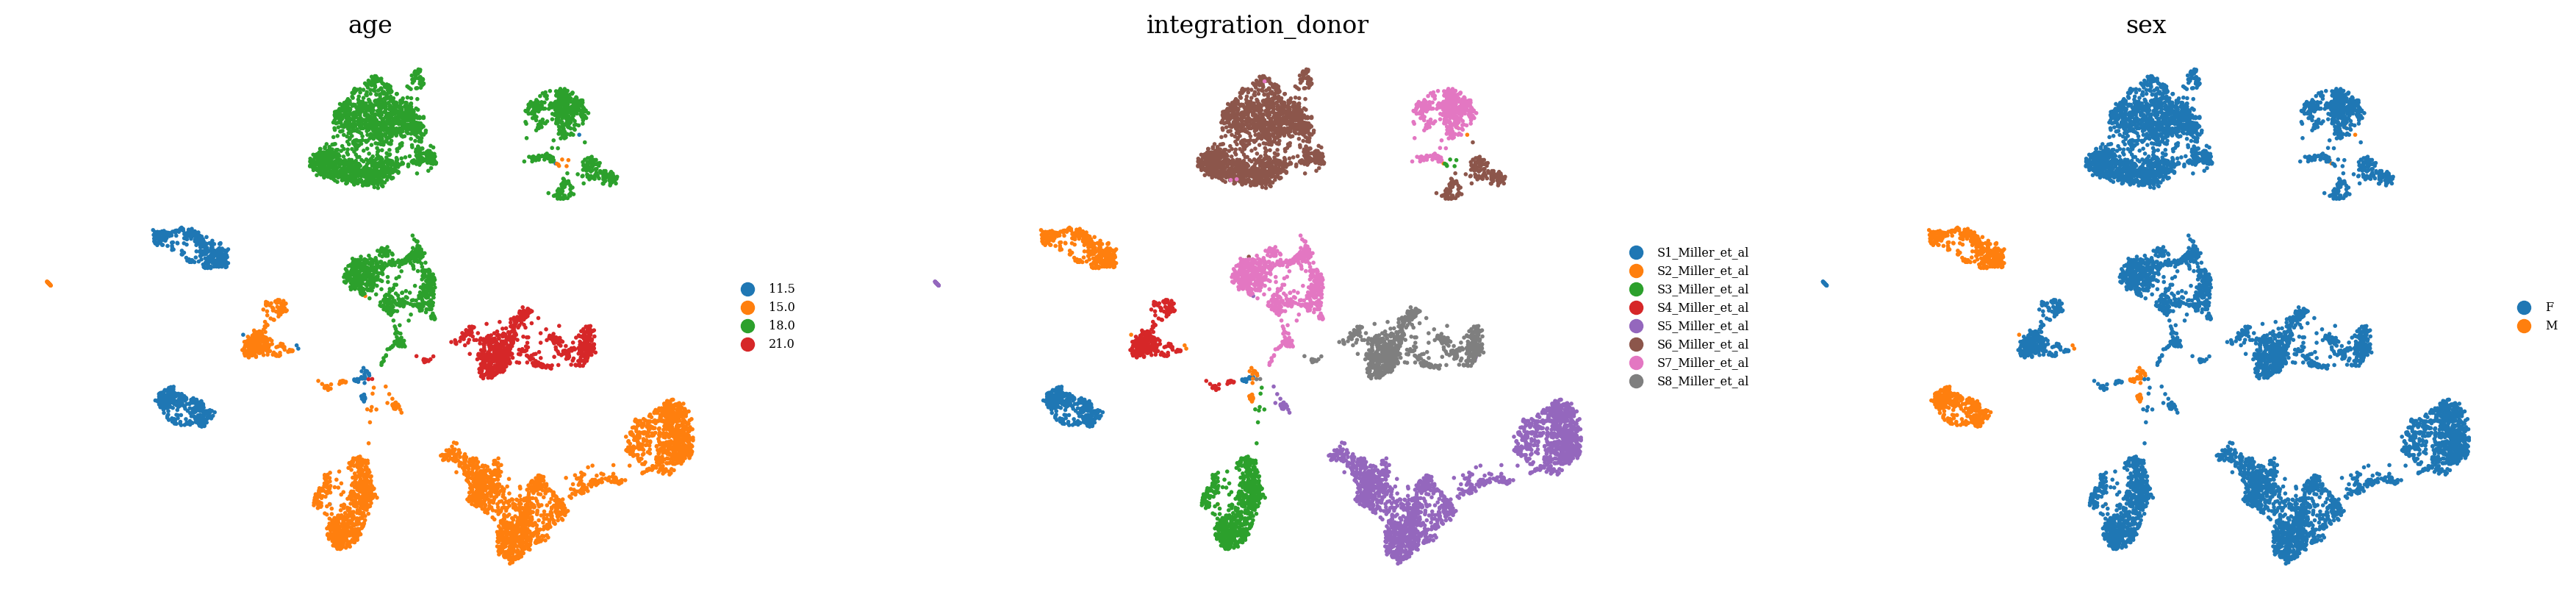

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

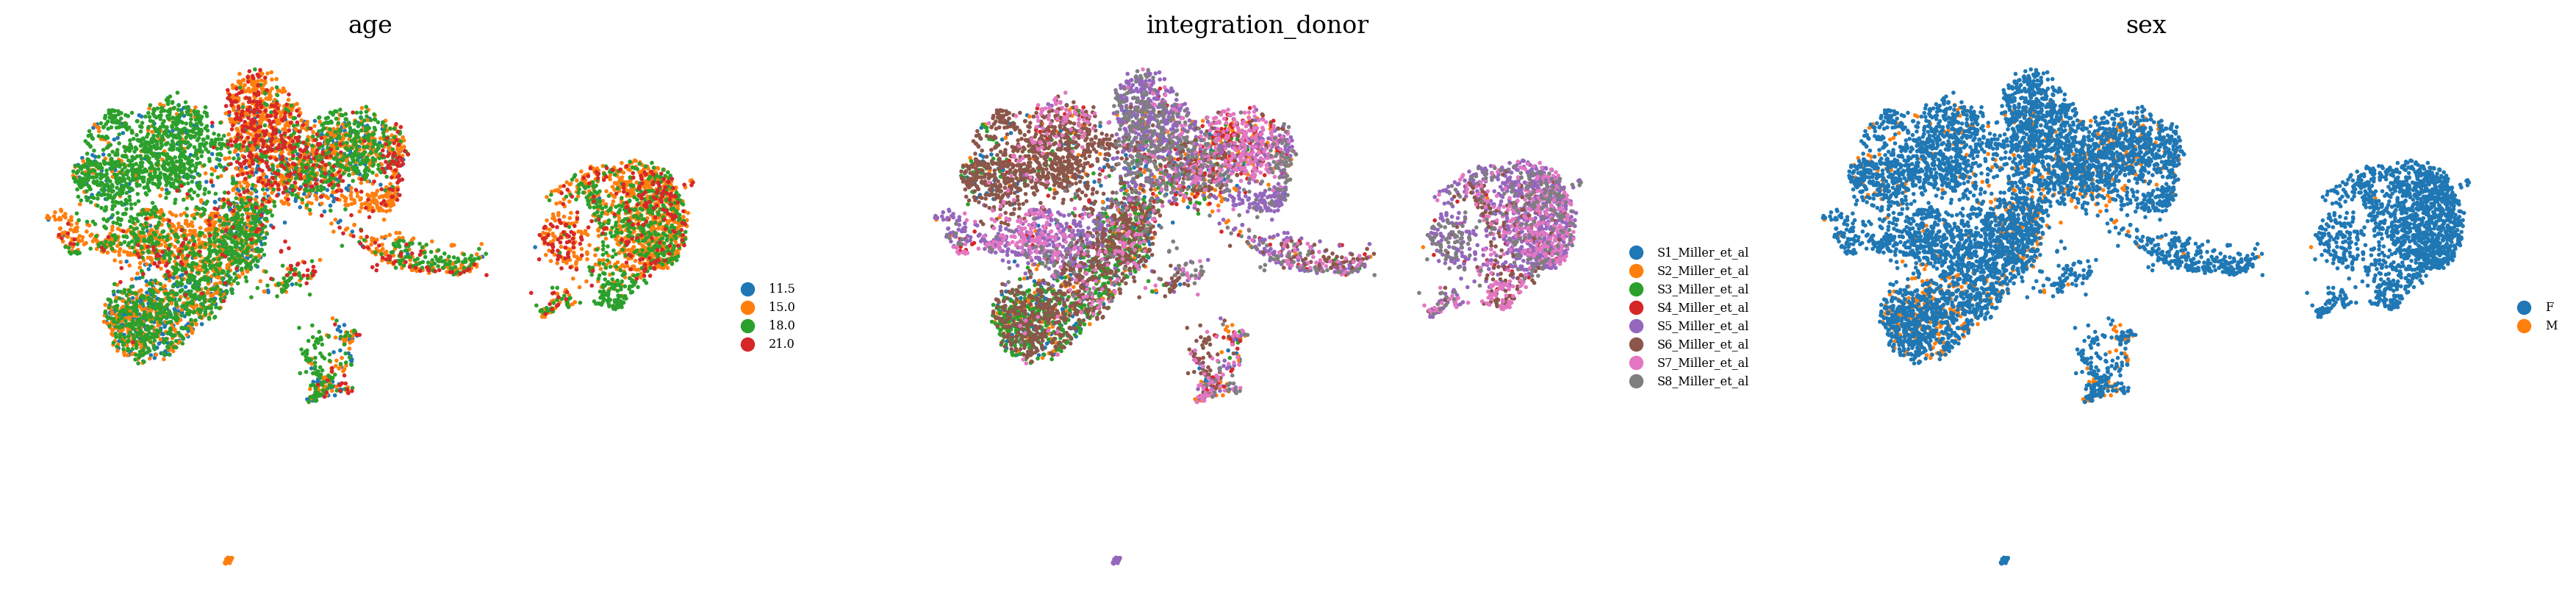

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  9%|▉         | 22/232 [00:00<00:00, 219.03it/s]

 20%|█▉        | 46/232 [00:00<00:00, 228.62it/s]

 30%|███       | 70/232 [00:00<00:00, 229.83it/s]

 41%|████      | 94/232 [00:00<00:00, 230.87it/s]

 51%|█████     | 118/232 [00:00<00:00, 231.34it/s]

 61%|██████    | 142/232 [00:00<00:00, 232.54it/s]

 72%|███████▏  | 166/232 [00:00<00:00, 233.94it/s]

 82%|████████▏ | 190/232 [00:00<00:00, 233.48it/s]

 92%|█████████▏| 214/232 [00:00<00:00, 231.87it/s]

100%|██████████| 232/232 [00:01<00:00, 231.07it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.14951013292530793

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)